## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(data_dir, 'membatross_embeddings.npy'))
feature_embeddings.shape

(49, 3, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [8]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 3)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [9]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[ -8.50796008,   4.06421417, -14.14677464],
       [-27.49406584,   8.97765114,   9.93112566],
       [-22.53874525,  25.13829916,  12.92493627],
       ...,
       [-16.87663121,  12.38163867, -10.87102044],
       [ -5.62744744,   8.8857026 ,  12.50605139],
       [-14.71606581,   2.88349557,  -7.40970974]])

In [10]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [11]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [12]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,cr,bigcat,cat_name
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument
4,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device
5,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture
...,...,...,...,...,...,...,...
1847,1847,-18.208906,9.885611,3.776987,0.803129,24,toy
1848,1848,-19.281246,4.272460,-1.785376,0.765881,10,food
1850,1850,-19.551059,2.813812,-2.150868,0.843158,10,food
1851,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal


<IPython.core.display.Javascript object>


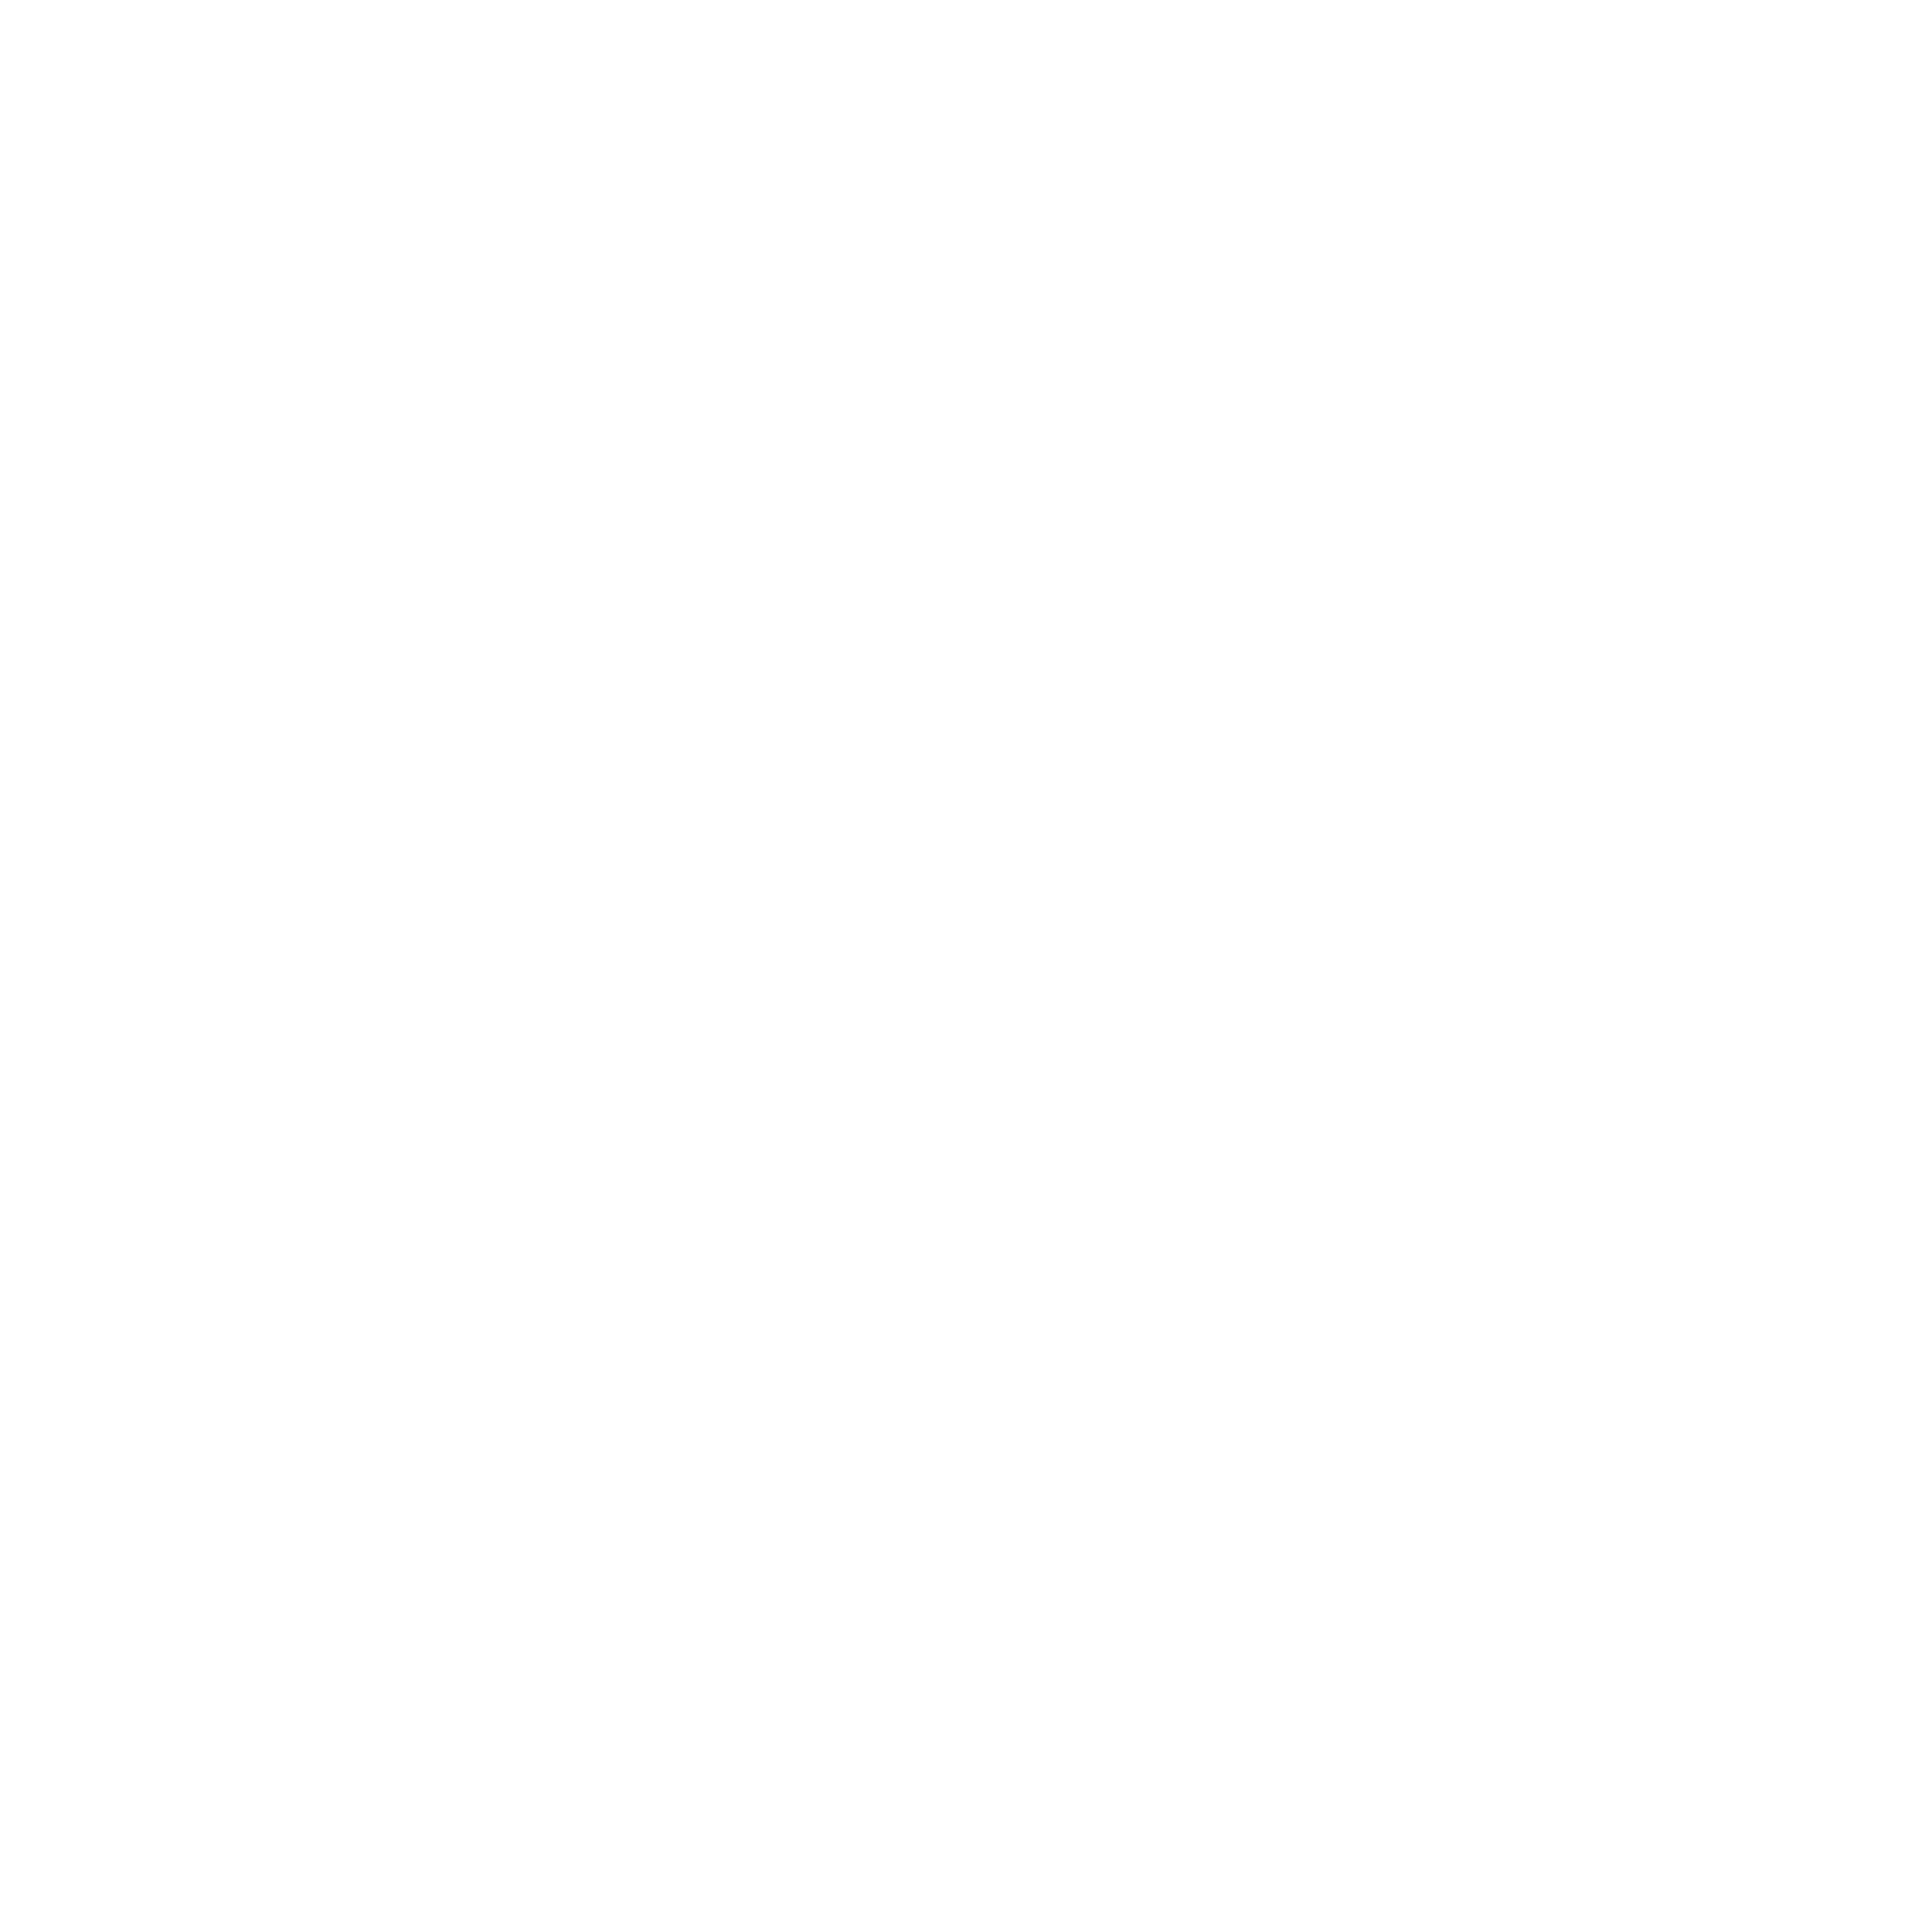

In [13]:
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.axes.set_xlim3d(left=-30, right=20) 
ax.axes.set_ylim3d(bottom=-30, top=20) 
ax.axes.set_zlim3d(bottom=-30, top=20) 
concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2]) 

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')

plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [14]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     66.84
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.92e-41
Time:                        14:28:59   Log-Likelihood:                -2535.3
No. Observations:                1854   AIC:                             5079.
Df Residuals:                    1850   BIC:                             5101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0785      0.006     13.998      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

,cart_coord_mem
rsquared,0.097791
rsquared_adj,0.096328
coef,"[0.07846746009500993, 0.02028530191834521, -0...."
pvalues,"[2.1373293819470823e-42, 0.0001032603576050088..."
AIC,5078.629906
BIC,5100.730309
F-statistic,66.841161
F-stats-prob,0.0
Log-Likelihood,-2535.314953


#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [16]:
### Polar coordinates of concepts in hyperbolic feature space
r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2]].values).T
plt.hist2d(theta, rho,
           bins = 20)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  5.,  2.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  2., 10., 13.,  7.,  2.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  4., 14., 14.,  7.,  5.,  6.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  4., 11., 22., 20., 15., 10.,  5.,
          1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  5., 12., 14., 27., 27., 26., 16., 11.,
          5.,  2.,  0.,  0.,  0.,  1.,  1.],
        [ 0.,  0.,  1.,  2.,  3., 14.,  7., 14., 19., 32., 32., 21., 10.,
          3.,  3.,  4.,  5.,  3.,  1.,  0.],
        [ 0.,  2.,  5.,  8., 22.,  9.,  8.,  9.,

In [17]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     48.97
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.89e-30
Time:                        14:28:59   Log-Likelihood:                -2559.9
No. Observations:                1854   AIC:                             5128.
Df Residuals:                    1850   BIC:                             5150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0546      0.006     -9.931      0.0

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


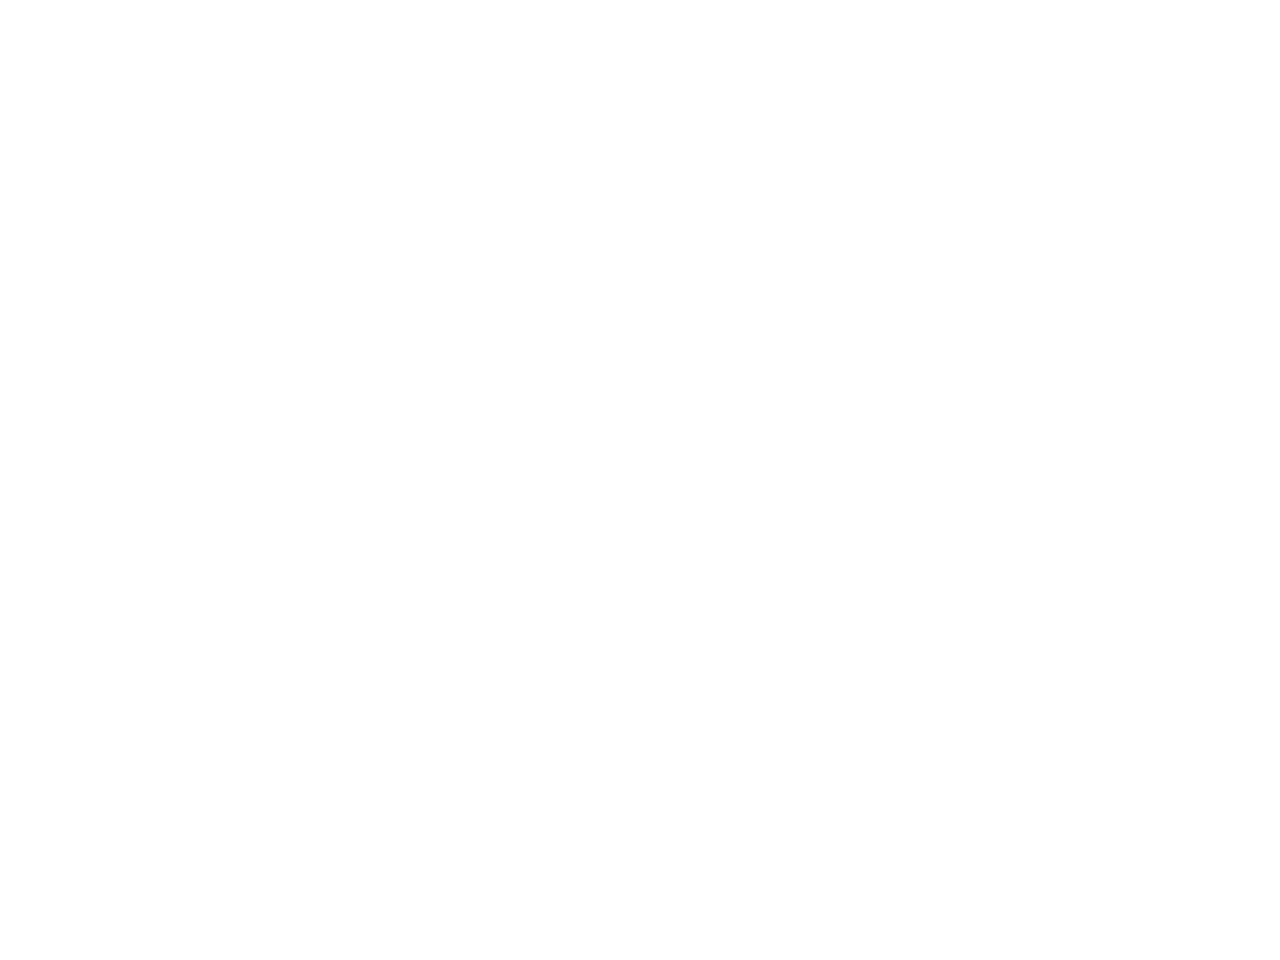

(array([ 43., 119., 218., 329., 406., 369., 229., 114.,  22.,   5.]),
 array([12.38486087, 14.85297531, 17.32108974, 19.78920417, 22.25731861,
        24.72543304, 27.19354747, 29.66166191, 32.12977634, 34.59789077,
        37.06600521]),
 <BarContainer object of 10 artists>)

In [18]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [19]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     71.58
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.33e-17
Time:                        14:28:59   Log-Likelihood:                -2595.6
No. Observations:                1854   AIC:                             5195.
Df Residuals:                    1852   BIC:                             5206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0451      0.005     -8.460      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results

,cart_coord_mem,radius_mem
rsquared,0.097791,0.037211
rsquared_adj,0.096328,0.036691
coef,"[0.07846746009500993, 0.02028530191834521, -0....","[-0.045069206500053485, 1.0576830361044065]"
pvalues,"[2.1373293819470823e-42, 0.0001032603576050088...","[5.3317390331325227e-17, 1.6426550643072648e-16]"
AIC,5078.629906,5195.119413
BIC,5100.730309,5206.169614
F-statistic,66.841161,71.577376
F-stats-prob,0.0,0.0
Log-Likelihood,-2535.314953,-2595.559706


#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

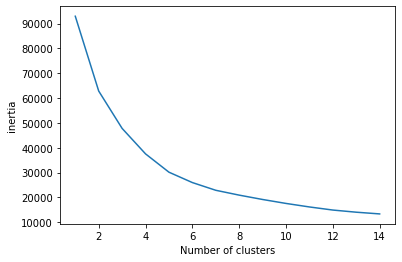

In [21]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [22]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-23.5264825 ,  13.32875646,  -3.37891637],
       [-17.95248956,  13.51341043,   0.78618591],
       [-18.7342096 ,   5.11833356,  -2.1847011 ],
       [-13.31458044,   9.12927484,  -8.96434954]])

<IPython.core.display.Javascript object>


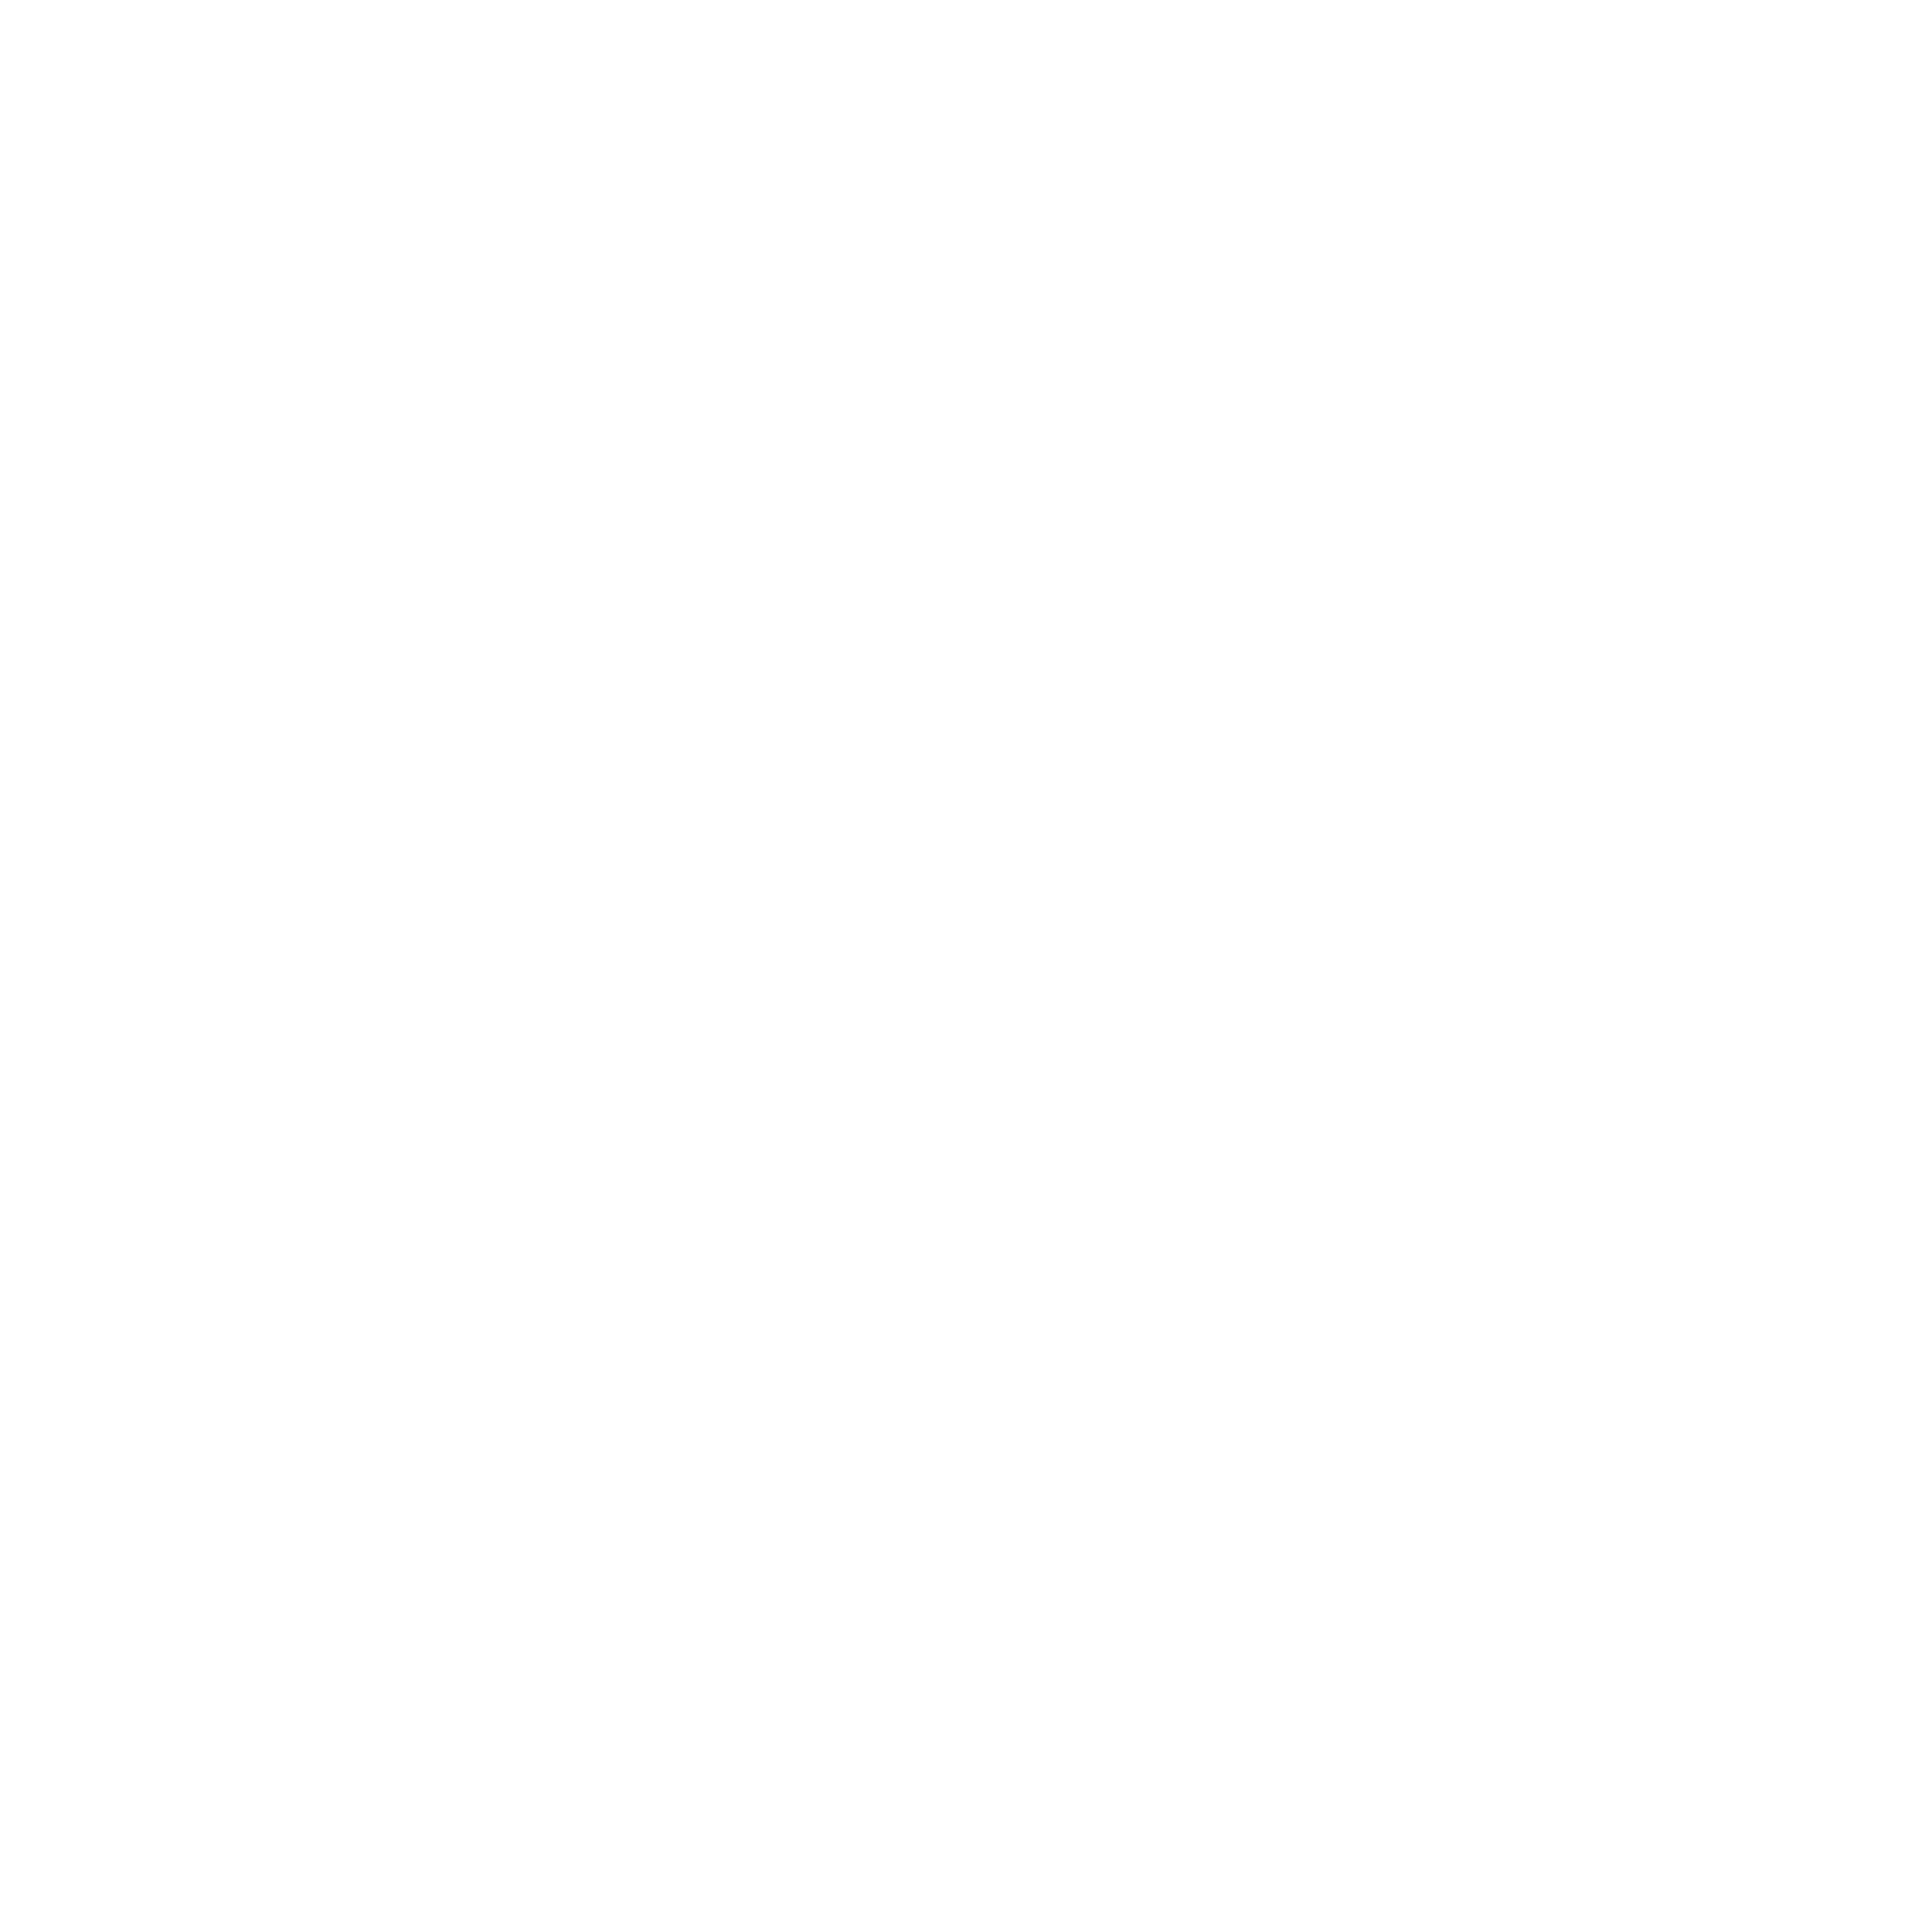

In [23]:
### clusters by memorability and plot concept coordinates in feature space
%matplotlib notebook


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [24]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.238
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00558
Time:                        14:29:01   Log-Likelihood:                -947.19
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0057      0.017      0.330      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.322
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00497
Time:                        14:29:01   Log-Likelihood:                -947.07
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0244      0.016      1.559      0.1

In [26]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.125
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0239
Time:                        14:29:01   Log-Likelihood:                -950.97
No. Observations:                 672   AIC:                             1906.
Df Residuals:                     670   BIC:                             1915.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0345      0.015      2.264      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     92.59
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.39e-49
Time:                        14:29:01   Log-Likelihood:                -736.59
No. Observations:                 600   AIC:                             1481.
Df Residuals:                     596   BIC:                             1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1288      0.013      9.992      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     89.52
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.87e-48
Time:                        14:29:01   Log-Likelihood:                -739.77
No. Observations:                 600   AIC:                             1488.
Df Residuals:                     596   BIC:                             1505.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0189      0.013     -1.434      0.1

In [29]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1913
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.662
Time:                        14:29:01   Log-Likelihood:                -851.27
No. Observations:                 600   AIC:                             1707.
Df Residuals:                     598   BIC:                             1715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0068      0.016      0.437      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     16.65
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.22e-10
Time:                        14:29:01   Log-Likelihood:                -556.56
No. Observations:                 409   AIC:                             1121.
Df Residuals:                     405   BIC:                             1137.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0665      0.023     -2.923      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     15.01
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.77e-09
Time:                        14:29:01   Log-Likelihood:                -558.78
No. Observations:                 409   AIC:                             1126.
Df Residuals:                     405   BIC:                             1142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0245      0.021      1.186      0.2

In [32]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.600
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0326
Time:                        14:29:01   Log-Likelihood:                -578.05
No. Observations:                 409   AIC:                             1160.
Df Residuals:                     407   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0392      0.018     -2.145      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     12.15
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.08e-07
Time:                        14:29:01   Log-Likelihood:                -228.59
No. Observations:                 173   AIC:                             465.2
Df Residuals:                     169   BIC:                             477.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1483      0.032      4.663      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     11.82
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.54e-07
Time:                        14:29:01   Log-Likelihood:                -229.00
No. Observations:                 173   AIC:                             466.0
Df Residuals:                     169   BIC:                             478.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0284      0.028     -1.014      0.3

In [35]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.544
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0345
Time:                        14:29:01   Log-Likelihood:                -243.21
No. Observations:                 173   AIC:                             490.4
Df Residuals:                     171   BIC:                             496.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0471      0.022     -2.132      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


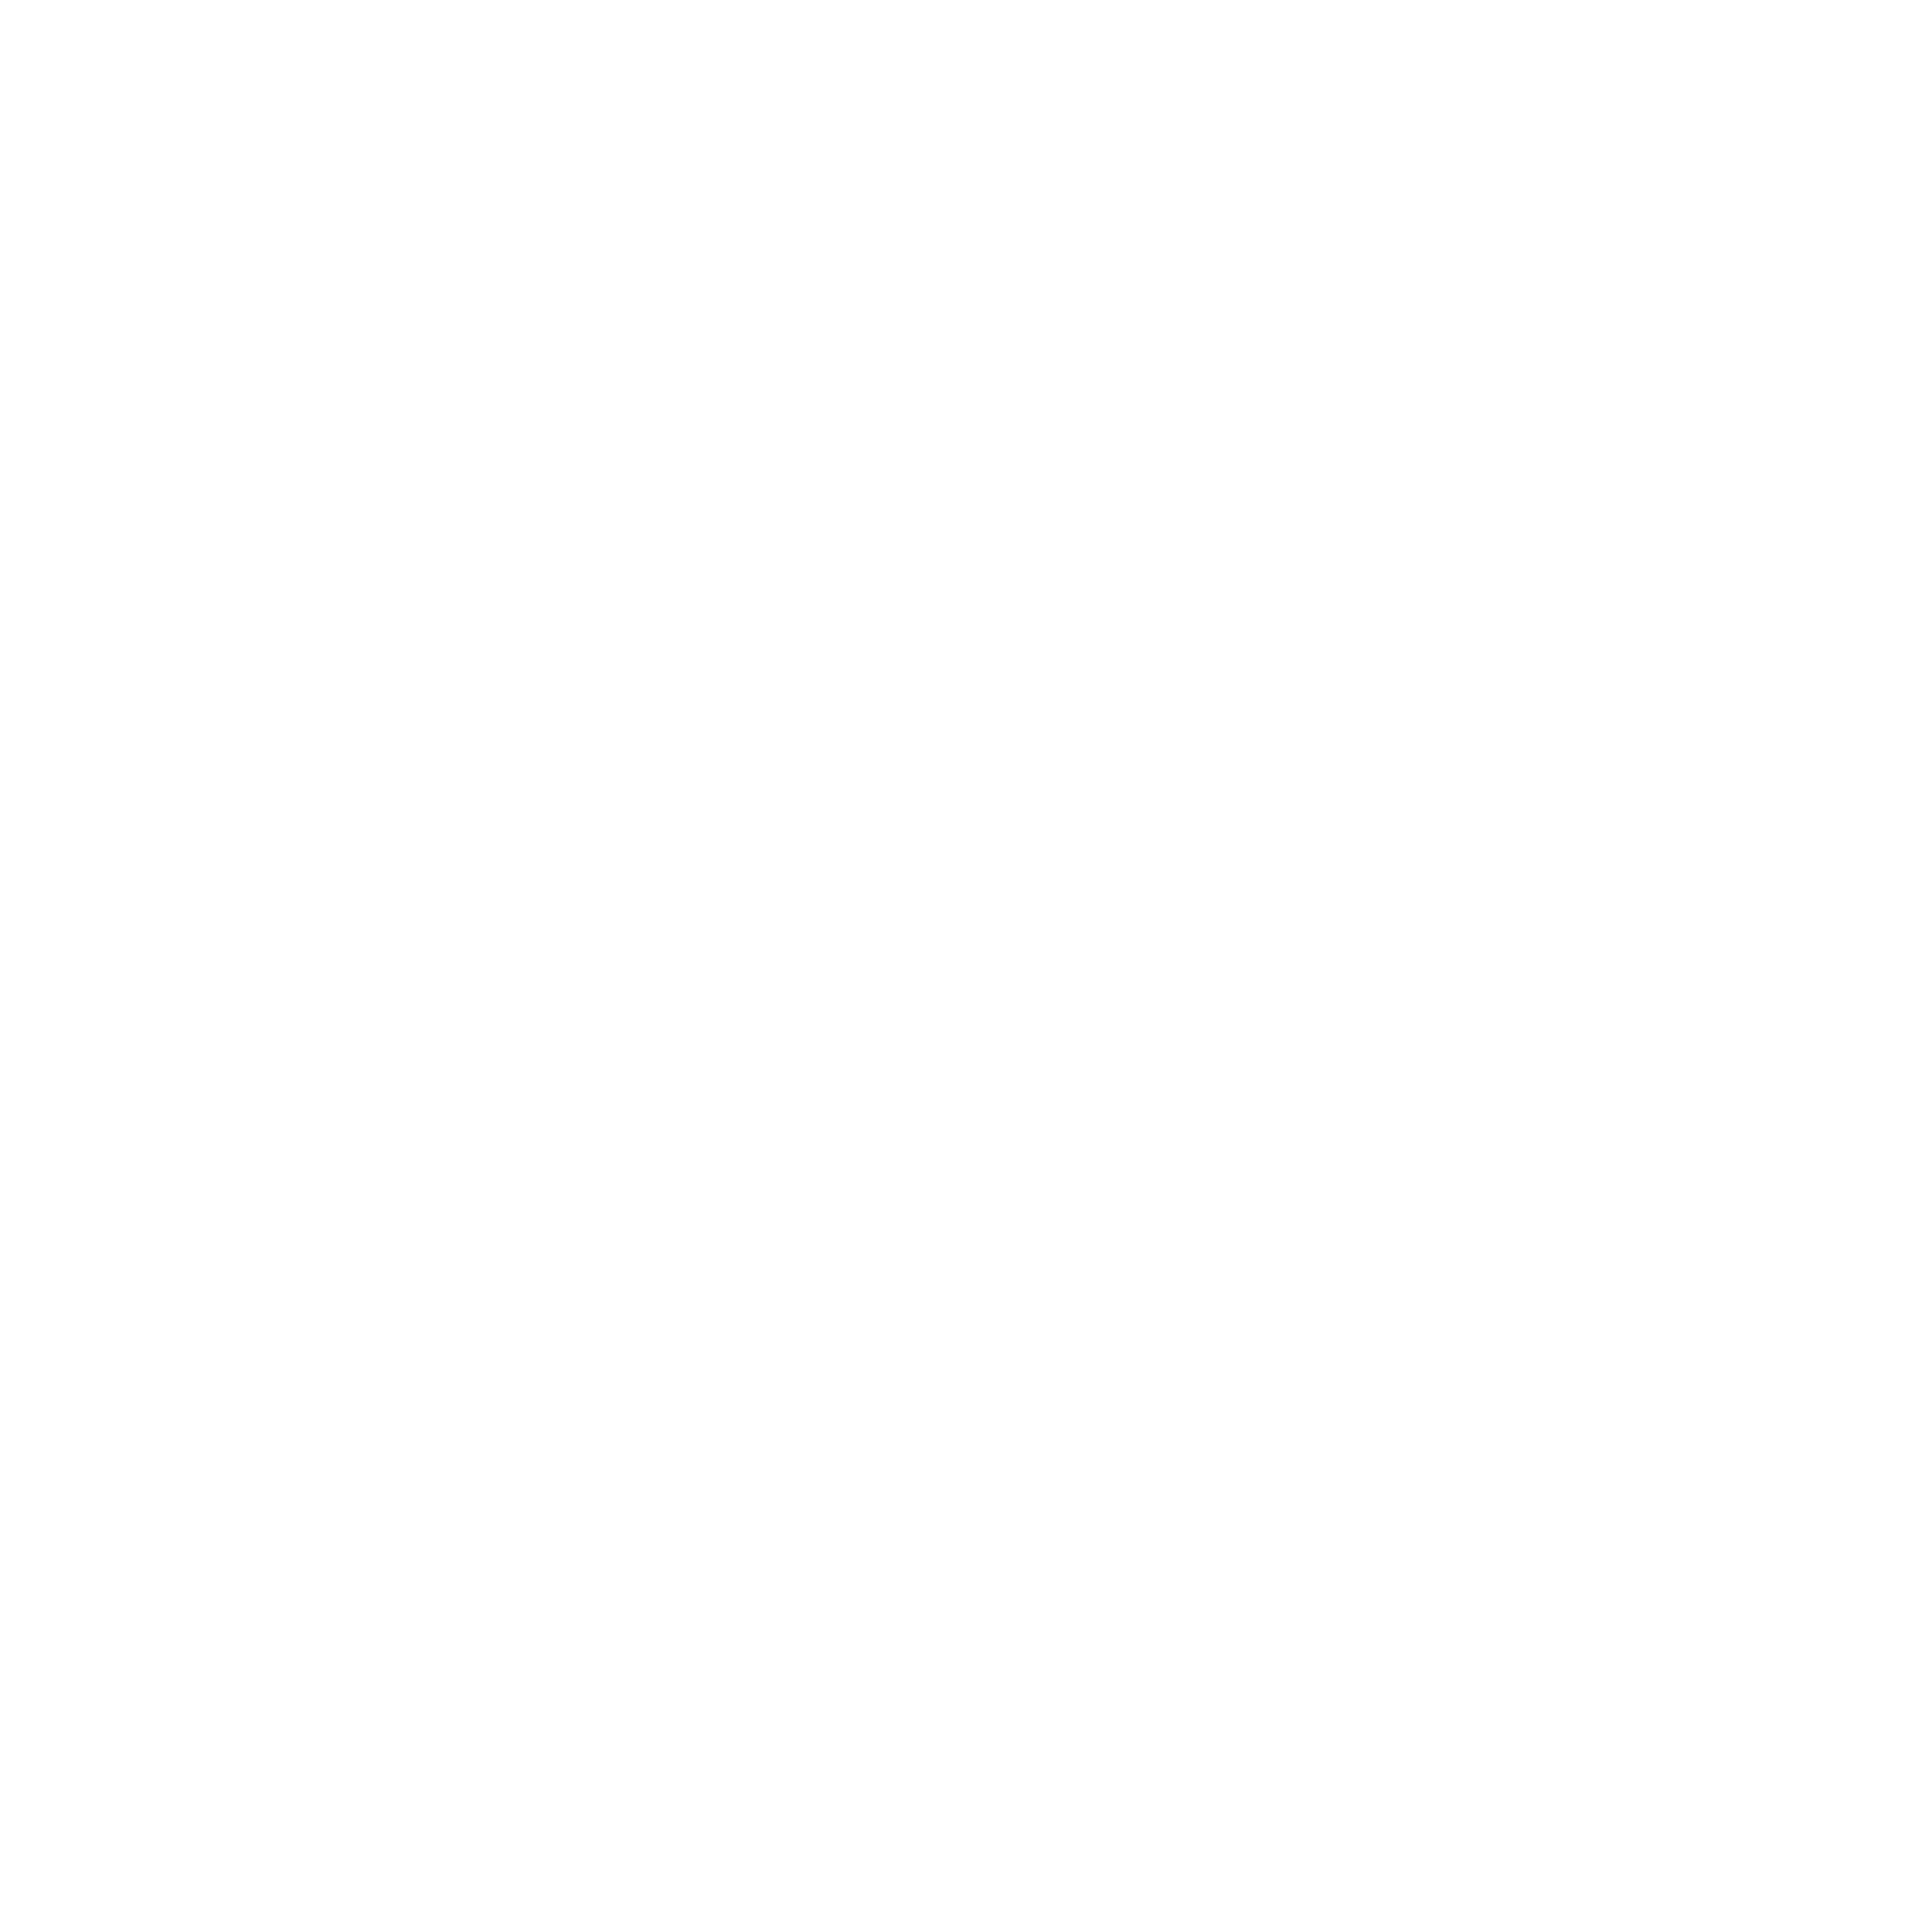

In [36]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


In [37]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.1504157690242467

In [38]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.14569454587996755

In [39]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.007735721905160586

### Analysis: coordinates, typicality, memorability


In [40]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [41]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,cr,bigcat,cat_name,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,0.810913
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0.247628
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0.624589
4,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0.522380
5,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...
1847,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,0.246697
1848,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,0.786900
1850,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,0.770485
1851,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,0.764335


In [42]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     404.4
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          2.80e-186
Time:                        14:29:01   Log-Likelihood:                -1447.1
No. Observations:                1324   AIC:                             2902.
Df Residuals:                    1320   BIC:                             2923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0993      0.005     19.365      0.0

In [43]:
### Polar coordinates vs. typicality
r, theta, rho = cart_to_polar(grouped[[0,1,2]].values).T

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     372.3
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          3.51e-175
Time:                        14:29:01   Log-Likelihood:                -1472.8
No. Observations:                1324   AIC:                             2954.
Df Residuals:                    1320   BIC:                             2974.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1259      0.005    -23.915      0.0

In [44]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     838.2
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          3.86e-143
Time:                        14:29:01   Log-Likelihood:                -1553.6
No. Observations:                1324   AIC:                             3111.
Df Residuals:                    1322   BIC:                             3122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1494      0.005    -28.951      0.0

In [45]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.50e-11
Time:                        14:29:01   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     39.48
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.92e-31
Time:                        14:29:01   Log-Likelihood:                -1803.8
No. Observations:                1324   AIC:                             3618.
Df Residuals:                    1319   BIC:                             3644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0737      0.008      9.691      0.0

In [47]:
### Polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     30.40
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.13e-24
Time:                        14:29:01   Log-Likelihood:                -1820.3
No. Observations:                1324   AIC:                             3651.
Df Residuals:                    1319   BIC:                             3677.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6734      0.191      3.529      0.0

In [48]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], concept_radius_typ]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     31.72
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.50e-14
Time:                        14:29:01   Log-Likelihood:                -1847.6
No. Observations:                1324   AIC:                             3701.
Df Residuals:                    1321   BIC:                             3717.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4547      0.183      2.483      0.0

#### Cluster level typicality

In [49]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [50]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,1,0.246697
1320,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900
1321,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485
1322,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335


In [51]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.295
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000376
Time:                        14:29:01   Log-Likelihood:                -496.13
No. Observations:                 357   AIC:                             1002.
Df Residuals:                     352   BIC:                             1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0543      0.025      2.152      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [52]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2]] = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.795
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           0.000888
Time:                        14:29:01   Log-Likelihood:                -497.09
No. Observations:                 357   AIC:                             1004.
Df Residuals:                     352   BIC:                             1024.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0164      0.024     -0.697      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [53]:
### cluster 0: radius vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.311
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0376
Time:                        14:29:01   Log-Likelihood:                -503.25
No. Observations:                 357   AIC:                             1013.
Df Residuals:                     354   BIC:                             1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0018      0.023      0.078      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [54]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     52.76
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.03e-36
Time:                        14:29:01   Log-Likelihood:                -538.70
No. Observations:                 441   AIC:                             1087.
Df Residuals:                     436   BIC:                             1108.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1313      0.016      8.446      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2]] = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     51.40
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.89e-35
Time:                        14:29:01   Log-Likelihood:                -540.57
No. Observations:                 441   AIC:                             1091.
Df Residuals:                     436   BIC:                             1112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0149      0.015     -0.960      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
### cluster 1: radius vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.870
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0578
Time:                        14:29:01   Log-Likelihood:                -622.88
No. Observations:                 441   AIC:                             1252.
Df Residuals:                     438   BIC:                             1264.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0202      0.018      1.107      0.2

In [57]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     15.35
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.35e-11
Time:                        14:29:01   Log-Likelihood:                -484.93
No. Observations:                 362   AIC:                             979.9
Df Residuals:                     357   BIC:                             999.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1014      0.026     -3.963      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [58]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2]] = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     14.08
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.11e-10
Time:                        14:29:01   Log-Likelihood:                -487.14
No. Observations:                 362   AIC:                             984.3
Df Residuals:                     357   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0560      0.023      2.423      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
### cluster 2: radius vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     13.03
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.43e-06
Time:                        14:29:02   Log-Likelihood:                -500.97
No. Observations:                 362   AIC:                             1008.
Df Residuals:                     359   BIC:                             1020.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0053      0.021     -0.258      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [60]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7.463
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.55e-05
Time:                        14:29:02   Log-Likelihood:                -218.60
No. Observations:                 164   AIC:                             447.2
Df Residuals:                     159   BIC:                             462.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1842      0.044      4.212      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2]] = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     7.121
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.67e-05
Time:                        14:29:02   Log-Likelihood:                -219.19
No. Observations:                 164   AIC:                             448.4
Df Residuals:                     159   BIC:                             463.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0293      0.031     -0.944      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 3: radius vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:2]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.087
Date:                Wed, 05 Oct 2022   Prob (F-statistic):             0.0483
Time:                        14:29:02   Log-Likelihood:                -229.62
No. Observations:                 164   AIC:                             465.2
Df Residuals:                     161   BIC:                             474.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0662      0.028     -2.372      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


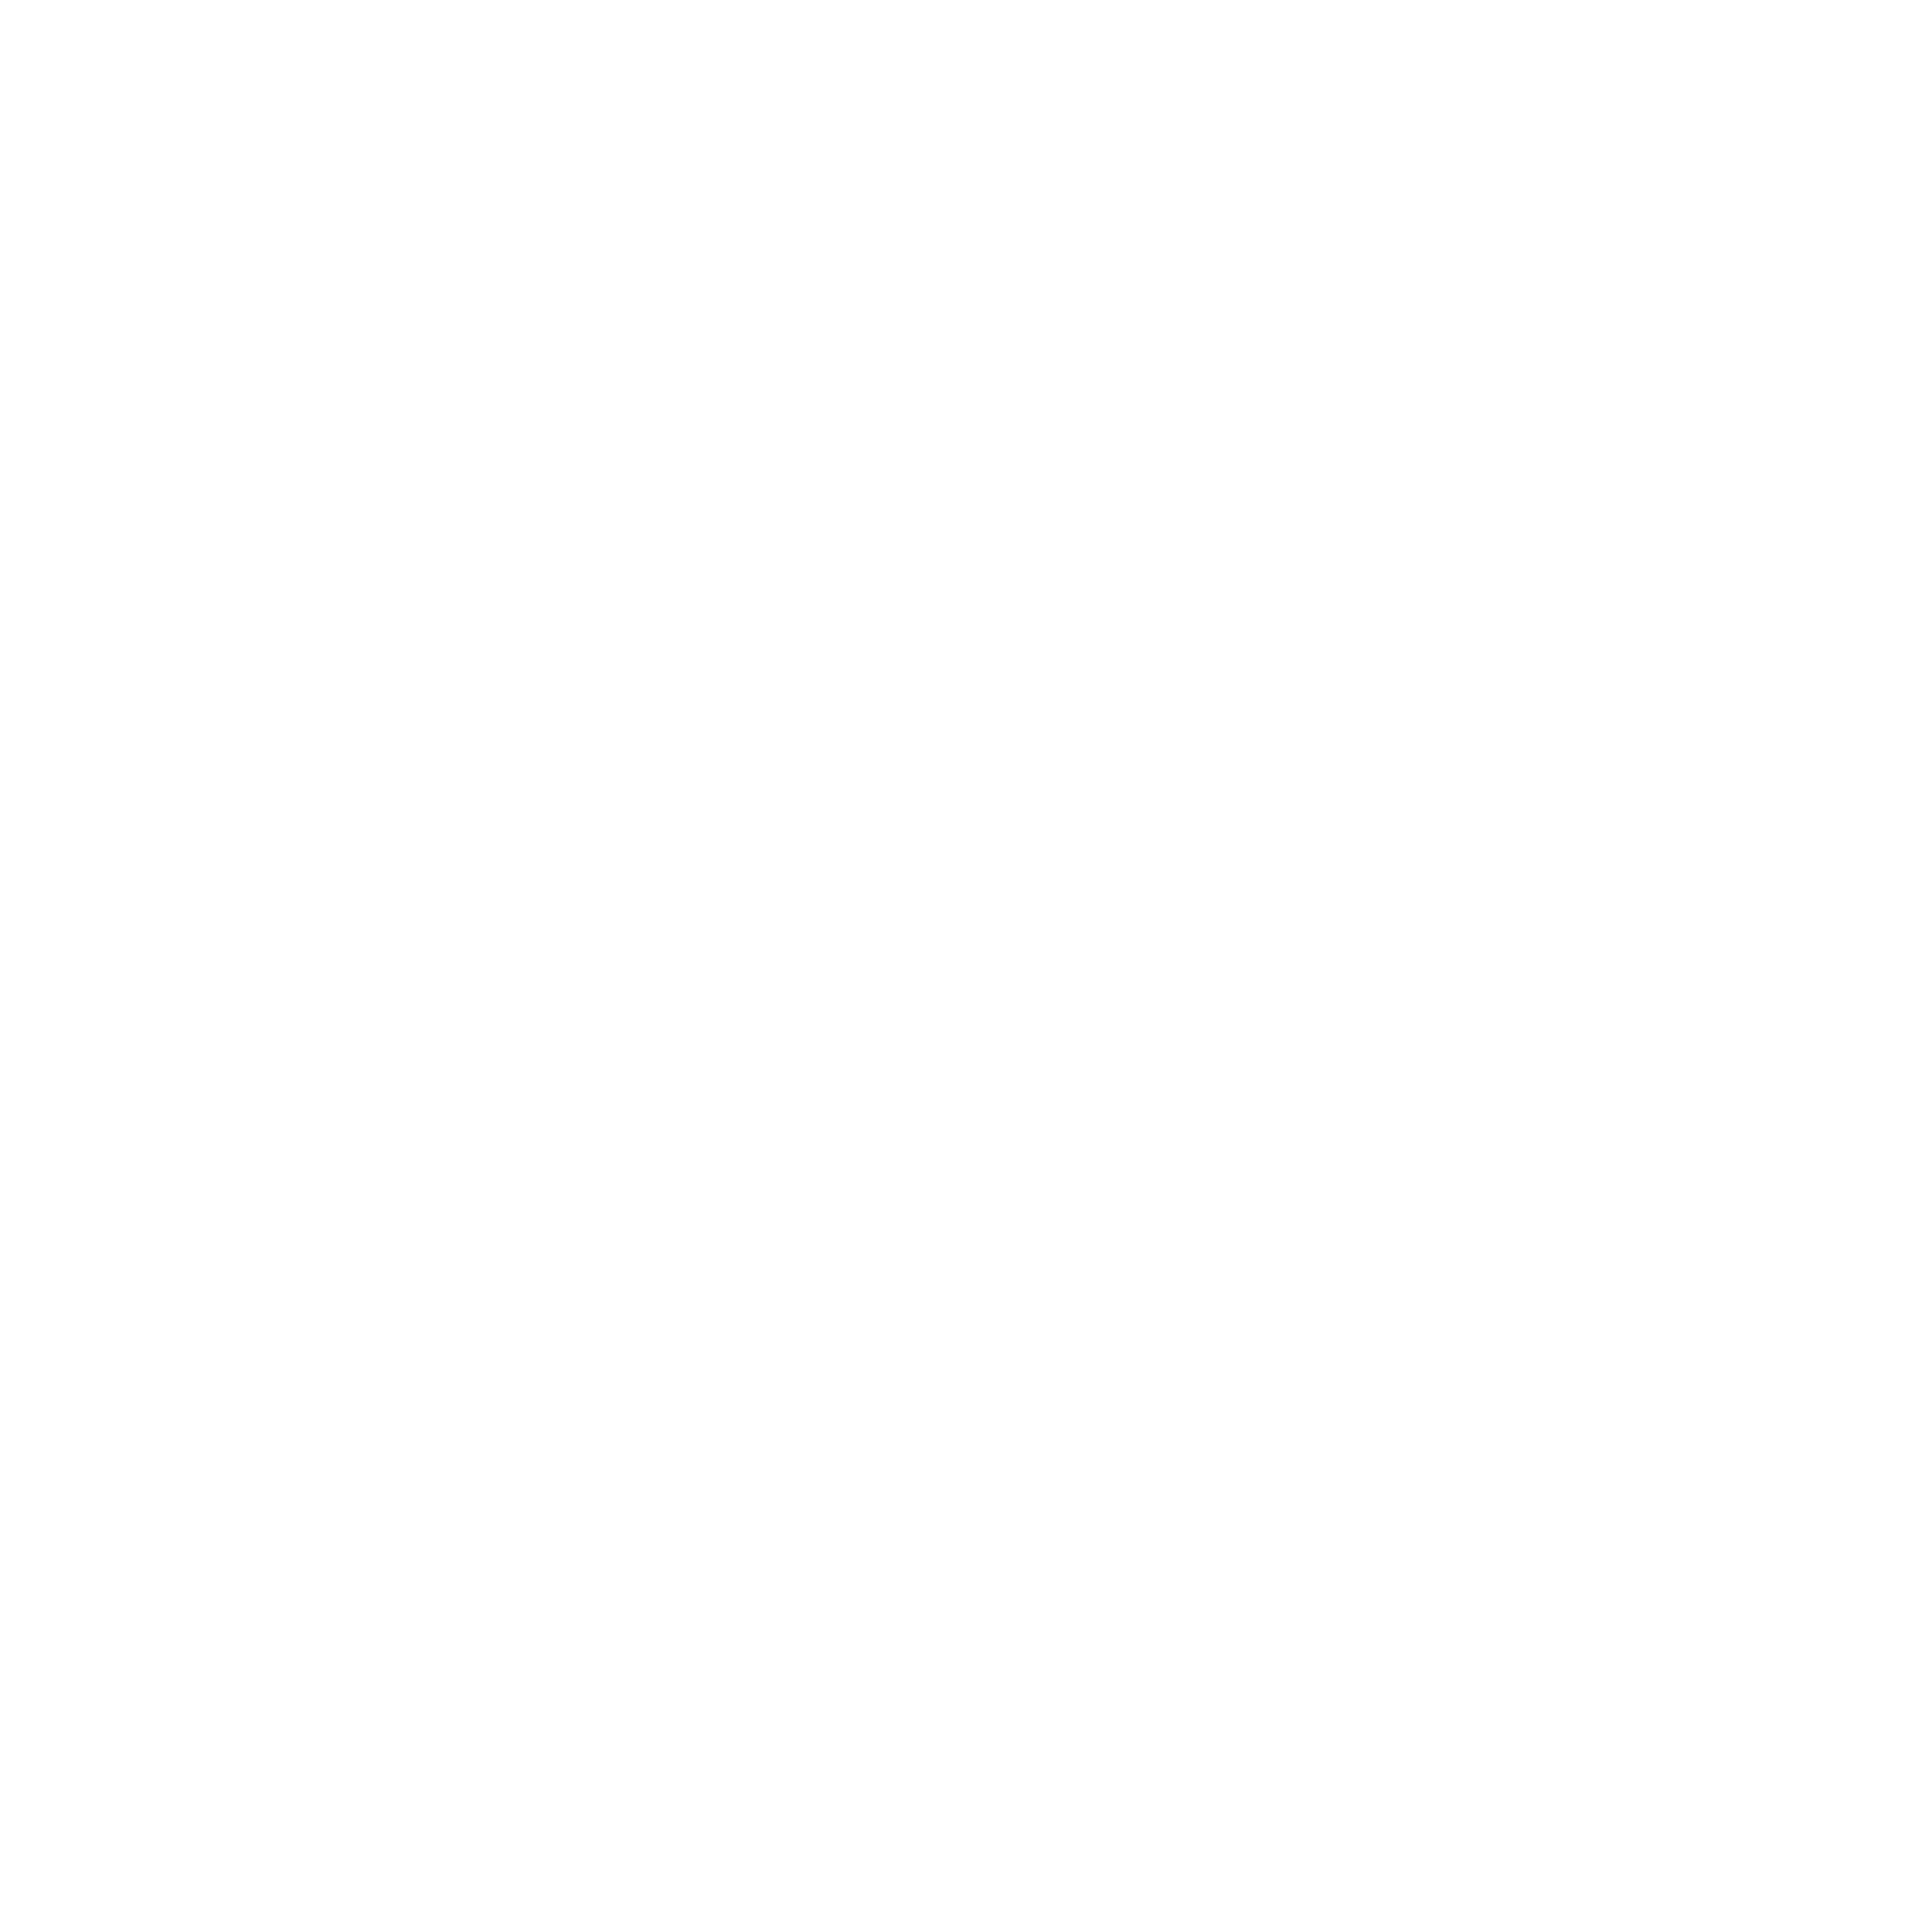

In [63]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [64]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.1836525405109798

In [65]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.17673968294922793

In [66]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.032343675826642215

In [67]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [68]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     38.43
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.99e-17
Time:                        14:29:02   Log-Likelihood:                -1841.2
No. Observations:                1324   AIC:                             3688.
Df Residuals:                    1321   BIC:                             3704.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1925      0.034      5.667      0.0

## Categories

<IPython.core.display.Javascript object>


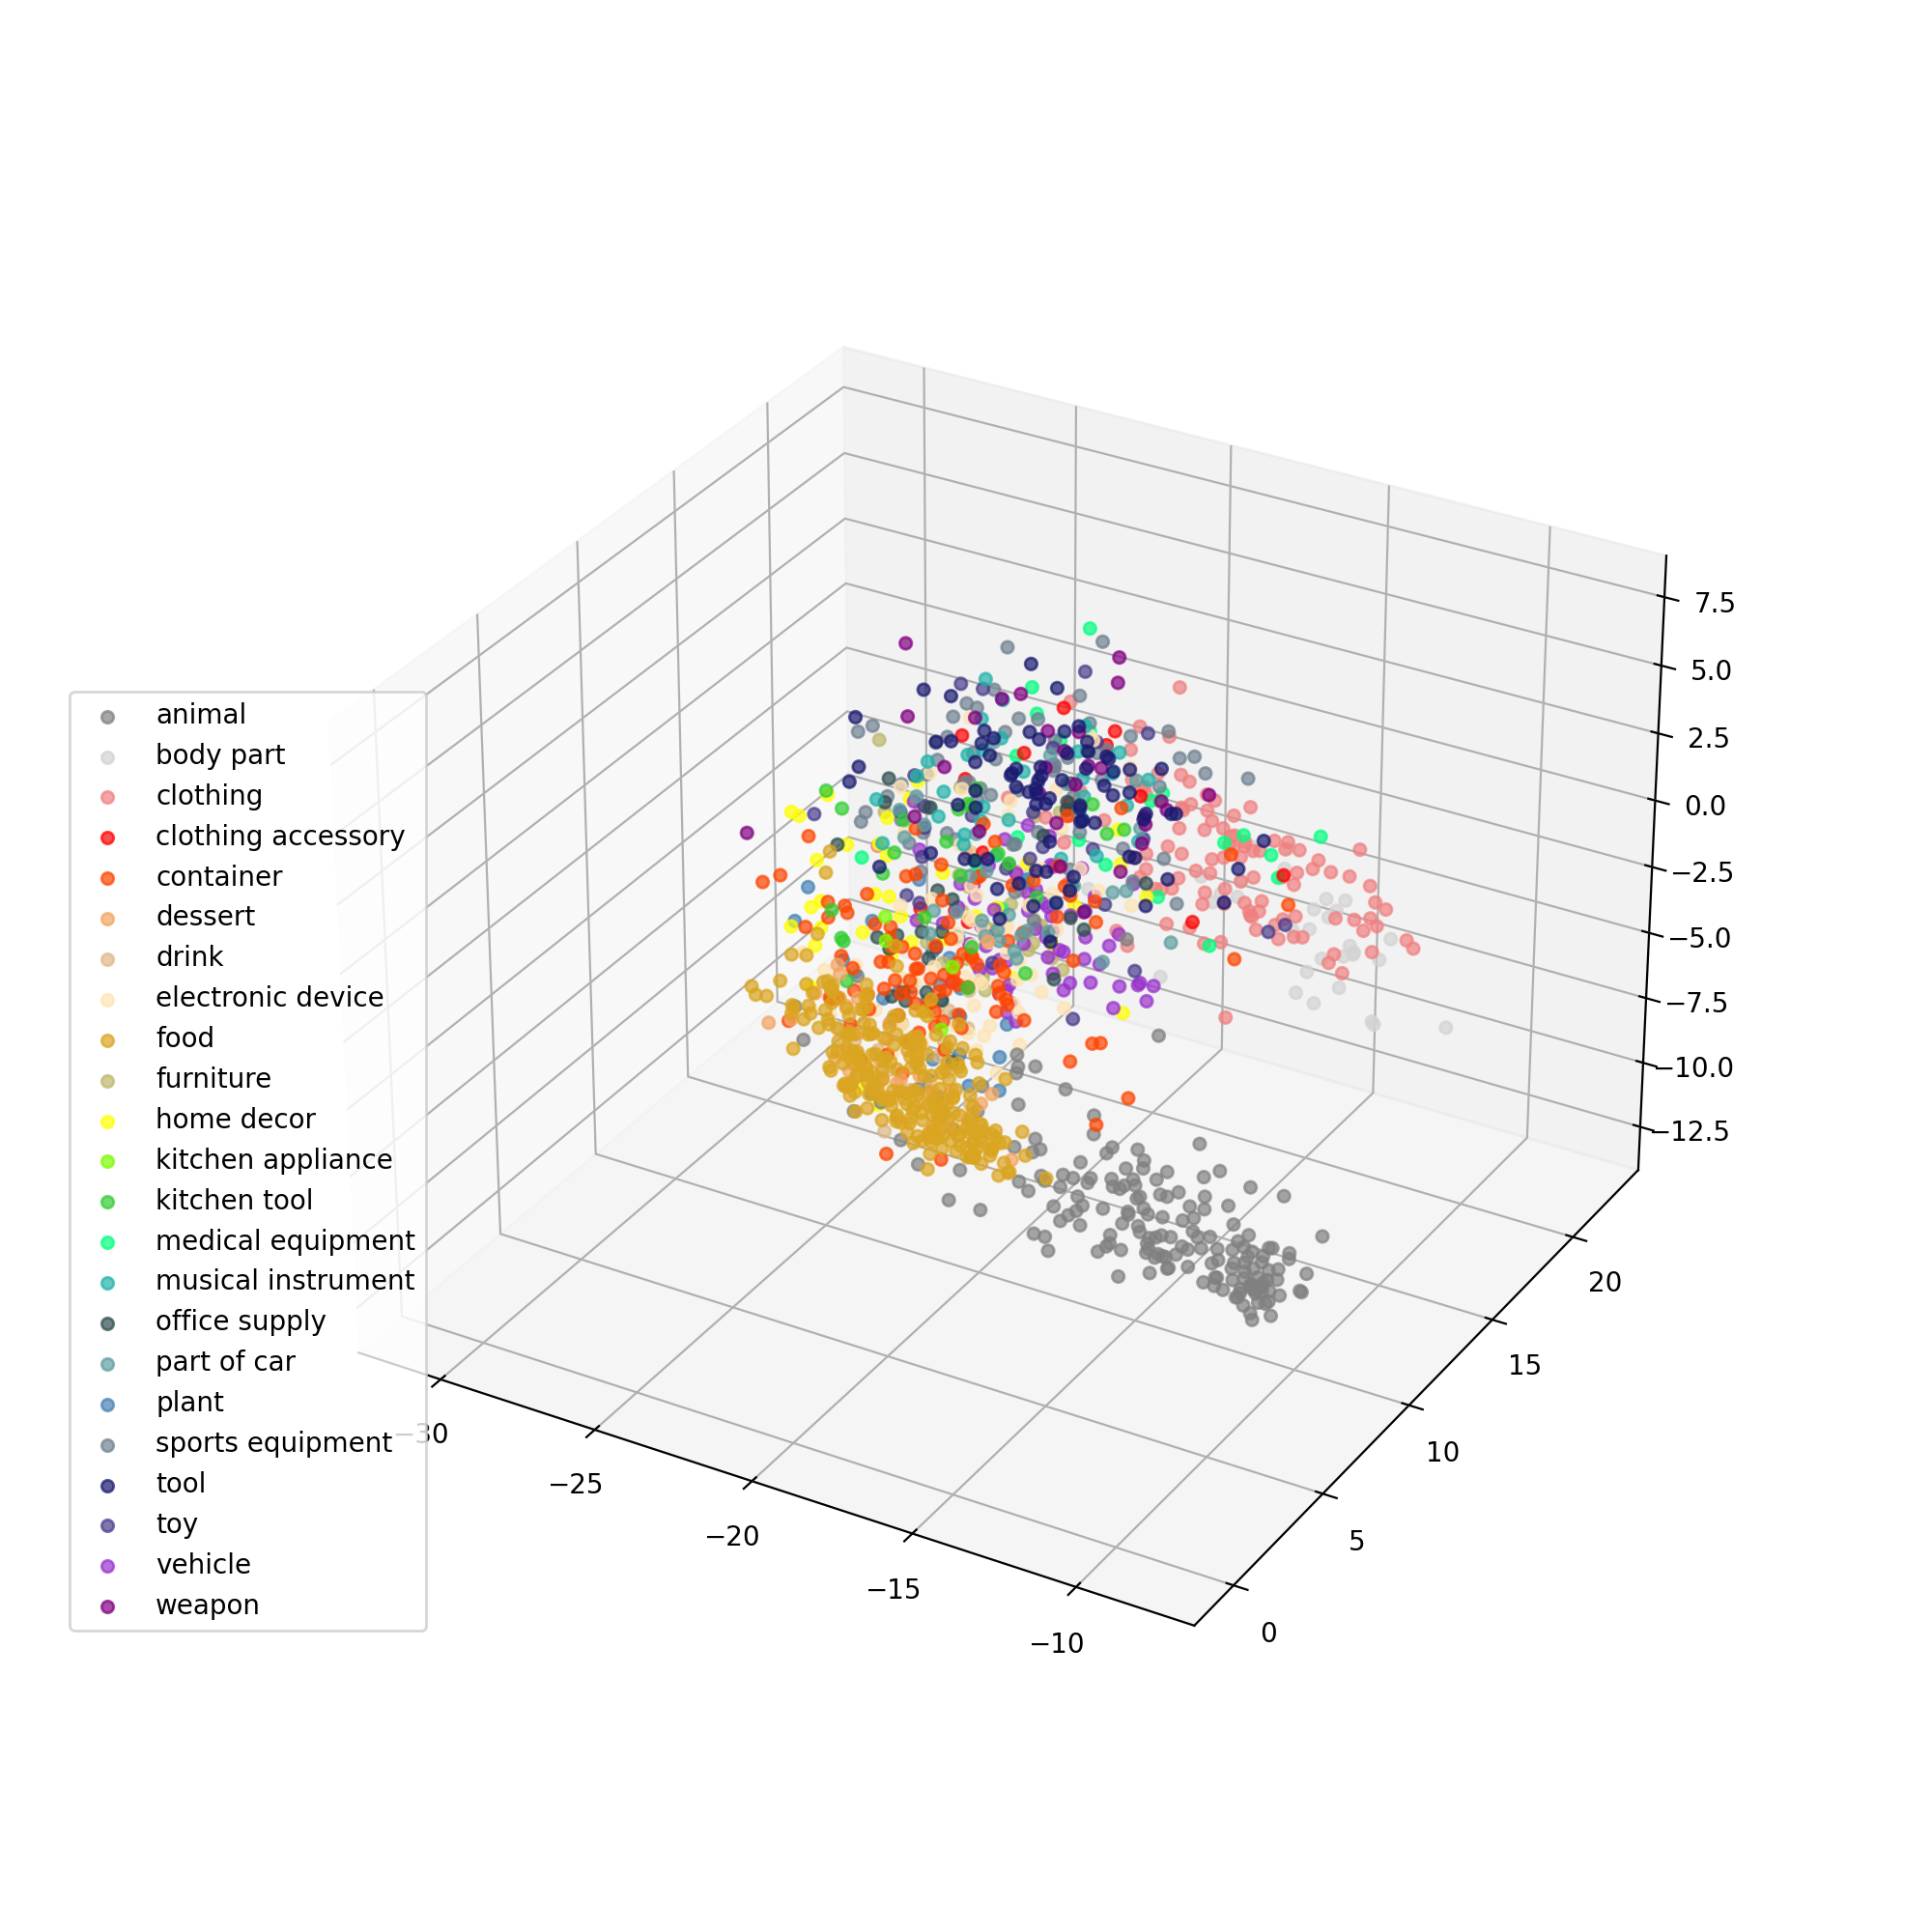

In [69]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [70]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.825943
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.159616
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.094532
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.158309
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.186518
...,...,...,...,...,...,...,...,...,...
1319,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,1,0.100659
1320,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.684158
1321,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.652066
1322,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.778959


In [71]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     897.6
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          4.84e-318
Time:                        14:29:02   Log-Likelihood:                -1142.6
No. Observations:                1324   AIC:                             2293.
Df Residuals:                    1320   BIC:                             2314.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0899      0.004     22.060      0.0

In [72]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     46.24
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.12e-36
Time:                        14:29:02   Log-Likelihood:                -1791.8
No. Observations:                1324   AIC:                             3594.
Df Residuals:                    1319   BIC:                             3620.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0602      0.008      7.736      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
### overall polar coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     905.7
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          8.91e-320
Time:                        14:29:02   Log-Likelihood:                -1138.6
No. Observations:                1324   AIC:                             2285.
Df Residuals:                    1320   BIC:                             2306.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1221      0.004    -29.853      0.0

In [74]:
### overall polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     40.27
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.29e-32
Time:                        14:29:02   Log-Likelihood:                -1802.4
No. Observations:                1324   AIC:                             3615.
Df Residuals:                    1319   BIC:                             3641.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0235      0.009     -2.685      0.0

In [75]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1168.
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          5.25e-184
Time:                        14:29:02   Log-Likelihood:                -1459.5
No. Observations:                1324   AIC:                             2923.
Df Residuals:                    1322   BIC:                             2933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1643      0.005    -34.180      0.0

In [76]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     34.71
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.04e-15
Time:                        14:29:02   Log-Likelihood:                -1844.8
No. Observations:                1324   AIC:                             3696.
Df Residuals:                    1321   BIC:                             3711.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0279      0.009     -3.164      0.0

In [77]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.34
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           6.31e-08
Time:                        14:29:02   Log-Likelihood:                -486.73
No. Observations:                 357   AIC:                             983.5
Df Residuals:                     352   BIC:                             1003.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0476      0.023      2.030      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [78]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2]] = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     9.986
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.15e-07
Time:                        14:29:02   Log-Likelihood:                -487.38
No. Observations:                 357   AIC:                             984.8
Df Residuals:                     352   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0260      0.022     -1.173      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     11.63
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           1.28e-05
Time:                        14:29:02   Log-Likelihood:                -495.20
No. Observations:                 357   AIC:                             996.4
Df Residuals:                     354   BIC:                             1008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0052      0.022     -0.239      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [80]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     59.76
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.24e-40
Time:                        14:29:02   Log-Likelihood:                -529.37
No. Observations:                 441   AIC:                             1069.
Df Residuals:                     436   BIC:                             1089.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1386      0.015      9.484      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2]] = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     58.29
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           2.14e-39
Time:                        14:29:02   Log-Likelihood:                -531.30
No. Observations:                 441   AIC:                             1073.
Df Residuals:                     436   BIC:                             1093.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0112      0.015     -0.767      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.260
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00553
Time:                        14:29:02   Log-Likelihood:                -620.52
No. Observations:                 441   AIC:                             1247.
Df Residuals:                     438   BIC:                             1259.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0094      0.018      0.535      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.83
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.36e-15
Time:                        14:29:02   Log-Likelihood:                -477.34
No. Observations:                 362   AIC:                             964.7
Df Residuals:                     357   BIC:                             984.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0208      0.032     -0.647      0.5

In [84]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2]] = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.82
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.47e-15
Time:                        14:29:02   Log-Likelihood:                -477.35
No. Observations:                 362   AIC:                             964.7
Df Residuals:                     357   BIC:                             984.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0125      0.024      0.524      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     35.66
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           7.46e-15
Time:                        14:29:02   Log-Likelihood:                -480.86
No. Observations:                 362   AIC:                             967.7
Df Residuals:                     359   BIC:                             979.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0050      0.019      0.268      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.215
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.77e-06
Time:                        14:29:02   Log-Likelihood:                -217.30
No. Observations:                 164   AIC:                             444.6
Df Residuals:                     159   BIC:                             460.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1886      0.040      4.771      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2]] = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     7.777
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           9.48e-06
Time:                        14:29:02   Log-Likelihood:                -218.05
No. Observations:                 164   AIC:                             446.1
Df Residuals:                     159   BIC:                             461.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0272      0.030     -0.913      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [88]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:2]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.774
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00150
Time:                        14:29:02   Log-Likelihood:                -226.08
No. Observations:                 164   AIC:                             458.2
Df Residuals:                     161   BIC:                             467.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0831      0.024     -3.395      0.0

In [89]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.2172039470704954

In [90]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.2134896696158729

In [91]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.07937119305187001

In [92]:
results.to_csv('../outputs/hbp3d_reg_results.csv')

### Typicality: human-rated vs. calculated

In [93]:
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


In [94]:
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,1,0.246697
1320,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900
1321,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485
1322,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335


In [95]:
typ_mapped = typ_coord_cluster.merge(concept_typicality_rated[['concept', 'typicality']], how='left', left_on='index', right_on='concept', suffixes=('_computed', '_rated'))
typ_mapped

,index,0,1,2,cr,bigcat,cat_name,label,typicality_computed,concept,typicality_rated
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913,0.0,4.874352
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628,1.0,2.613022
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589,2.0,5.605201
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380,4.0,5.966682
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185,5.0,4.451417
...,...,...,...,...,...,...,...,...,...,...,...
1646,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900,1848.0,7.064713
1647,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485,1850.0,4.520777
1648,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335,1851.0,7.177455
1649,1853,-18.651758,5.749045,-4.932768,0.823237,10,food,2,0.705398,1853.0,6.354120


In [96]:
typ_mapped_drop_na = typ_mapped.dropna()
typ_mapped_drop_na

,index,0,1,2,cr,bigcat,cat_name,label,typicality_computed,concept,typicality_rated
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913,0.0,4.874352
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628,1.0,2.613022
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589,2.0,5.605201
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380,4.0,5.966682
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185,5.0,4.451417
...,...,...,...,...,...,...,...,...,...,...,...
1646,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900,1848.0,7.064713
1647,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485,1850.0,4.520777
1648,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335,1851.0,7.177455
1649,1853,-18.651758,5.749045,-4.932768,0.823237,10,food,2,0.705398,1853.0,6.354120


In [97]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_computed'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     57.92
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.62e-14
Time:                        14:29:02   Log-Likelihood:                -2268.8
No. Observations:                1619   AIC:                             4542.
Df Residuals:                    1617   BIC:                             4552.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
typicality_computed     1.0052    

In [98]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_rated'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.003487
Date:                Wed, 05 Oct 2022   Prob (F-statistic):              0.953
Time:                        14:29:02   Log-Likelihood:                -2297.3
No. Observations:                1619   AIC:                             4599.
Df Residuals:                    1617   BIC:                             4609.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated    -0.0011      0.018  

In [99]:
stats.spearmanr(typ_mapped_drop_na['typicality_computed'], typ_mapped_drop_na['typicality_rated'])

SpearmanrResult(correlation=0.2752464336064262, pvalue=1.5535820210715816e-29)

In [100]:
clusters

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.825943
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.159616
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.094532
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.158309
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.186518
...,...,...,...,...,...,...,...,...,...
1319,1847,-18.208906,9.885611,3.776987,0.803129,24,toy,1,0.100659
1320,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.684158
1321,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.652066
1322,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.778959


In [101]:
typ_mapped_drop_na = typ_mapped_drop_na.merge(clusters[['index', 'typicality']], how='left', left_on='index', right_on='index').rename(columns={'typicality':'typicality_cluster'})
typ_mapped_drop_na = typ_mapped_drop_na.dropna()
typ_mapped_drop_na


,index,0,1,2,cr,bigcat,cat_name,label,typicality_computed,concept,typicality_rated,typicality_cluster
0,0,-8.362256,5.447828,-8.557188,0.779739,1,animal,3,0.810913,0.0,4.874352,0.825943
1,1,-26.123590,12.240625,0.518939,0.798485,13,home decor,0,0.247628,1.0,2.613022,0.159616
2,2,-24.385152,14.180849,0.693800,0.752845,18,musical instrument,0,0.624589,2.0,5.605201,0.094532
3,4,-20.330699,11.947785,-4.992442,0.794466,9,electronic device,0,0.522380,4.0,5.966682,0.158309
4,5,-24.493047,16.661652,-4.482670,0.806000,12,furniture,0,0.509185,5.0,4.451417,0.186518
...,...,...,...,...,...,...,...,...,...,...,...,...
1614,1848,-19.281246,4.272460,-1.785376,0.765881,10,food,2,0.786900,1848.0,7.064713,0.684158
1615,1850,-19.551059,2.813812,-2.150868,0.843158,10,food,2,0.770485,1850.0,4.520777,0.652066
1616,1851,-14.748351,9.486465,-8.609210,0.800163,1,animal,3,0.764335,1851.0,7.177455,0.778959
1617,1853,-18.651758,5.749045,-4.932768,0.823237,10,food,2,0.705398,1853.0,6.354120,0.561689


In [102]:
stats.spearmanr(typ_mapped_drop_na['typicality_cluster'], typ_mapped_drop_na['typicality_rated'])

SpearmanrResult(correlation=0.1583723951681643, pvalue=1.474821689640137e-10)

In [103]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_cluster'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     63.19
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           3.50e-15
Time:                        14:29:02   Log-Likelihood:                -2266.2
No. Observations:                1619   AIC:                             4536.
Df Residuals:                    1617   BIC:                             4547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
typicality_cluster     0.8039      0

In [104]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     38.43
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           5.47e-24
Time:                        14:29:02   Log-Likelihood:                -2241.4
No. Observations:                1619   AIC:                             4491.
Df Residuals:                    1615   BIC:                             4512.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0467      0.006      7.210      0.0

In [105]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(np.sqrt((typ_mapped_drop_na[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 05 Oct 2022   Prob (F-statistic):           4.91e-26
Time:                        14:29:02   Log-Likelihood:                -2241.5
No. Observations:                1619   AIC:                             4487.
Df Residuals:                    1617   BIC:                             4498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0633      0.006    -10.739      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [106]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_computed'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_rated'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     typicality_computed   R-squared:                       0.082
Model:                             OLS   Adj. R-squared:                  0.081
Method:                  Least Squares   F-statistic:                     144.2
Date:                 Wed, 05 Oct 2022   Prob (F-statistic):           6.93e-32
Time:                         14:29:02   Log-Likelihood:                -2228.1
No. Observations:                 1619   AIC:                             4460.
Df Residuals:                     1617   BIC:                             4471.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated     0.2128   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
